# Binary Classification with PyTorch 

In this training, we will use PyTorch to build a simple neural network for binary classification. We will use the `torch` and `torchvision` libraries to build and train the model. We will use the `sklearn` library to evaluate the model. 
The outcome of the model will predict if the Total Row score C of a patient is above or below a certain value, in this case we have defined the threshold as 5 e.g. if the Total Row score C is above 5, the outcome is class 1, otherwise it is  class 0.


In [336]:
# import libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization, Dropout
import sklearn
import keras
from tensorflow.keras.optimizers.legacy import Adam
from scikeras.wrappers import KerasRegressor
from keras.layers import Dropout
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras import regularizers

### We then need to define some functions to help with the classification 
We will define the following functions: `pin_update`: this function makes a returns a 1 if the total row score is below 5 or else a 0. \
Then `pin_update1`: This function return a 1 is the total row score is above 5 or else a 0. \
Then we have created `predict_round` which is a function that returns the rounded value of the prediction, and the estimated class

In [337]:
def pin_update(row):
    if row["Total Row Score C"] <= 5:
        return 0
    else:
        return 1


def pin_update1(row):
     if 5 < row["Total Row Score C"]:
          return 0
     else:
          return 1


def predict_round(pred):
    if pred[0] > pred[1]:
        return f"the estimate would be class 1 with a probability of {pred[0]*100}"
    else: 
        return f"The estimate would be class 2 with a probability of {pred[1]*100}"

In [338]:
df = pd.read_csv('Data for python.csv', sep=';', header=1, index_col=0, decimal=',')
df = df.drop(columns=['Id'])
df = df.drop(columns=['ScandcleftID'])
df = df.drop(columns=['Født'])
df = df.drop(columns=['Materialedato A'])
df = df.drop(columns=['Materialedato B'])
df = df.drop(columns=['Materialedato C'])
df = df.iloc[1:, :]


We then normalized data to have $MEAN = 0$ and $STD = 1$ using the `Normalization` from `keras` library. We do this to ensure that the model trains faster and better. 


In [339]:
scaler = MinMaxScaler()
scaler.fit(df)
df1 = scaler.transform(df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Here we then apply the two functions createde above to the data to sperate the data into two classes.

In [340]:
Output = df.apply(pin_update, axis=1)
Output1 = df.apply(pin_update1, axis=1)
df['Output'] = Output
df['Output1'] = Output1


df1 = df[["Anteroposterior 1",
          'Anteroposterior 2',
          'Vertical 1',
          'Vertical 2',
          'Transverse',
          'Crowding ',
          'Spacing',
          'Tooth shape/size\r\n',
          "Pan 2\r\n",
          'Total Row Score A',
          'Anteroposterior 1.1',
          'Anteroposterior',
          'Vertical 1.1',
          'Vertical 2.1',
          'Transverse.1',
          'Crowding .2',
          'Spacing.1',
          'Tooth shape/size\r\n.1',
          'Pan 2\r\n.1',
          'Total Row Score B',
          'Output',
          'Output1']]

df1 = df1.dropna()


df1 

,Anteroposterior 1,Anteroposterior 2,Vertical 1,Vertical 2,Transverse,Crowding,Spacing,Tooth shape/size\r\n,Pan 2\r\n,Total Row Score A,...,Vertical 1.1,Vertical 2.1,Transverse.1,Crowding .2,Spacing.1,Tooth shape/size\r\n.1,Pan 2\r\n.1,Total Row Score B,Output,Output1
Center,,,,,,,,,,,,,,,,,,,,,
H,9.0,0.0,0.0,0.0,6.0,0.0,4.0,0.0,4.0,23,...,0.0,0.0,6.0,0.0,4.0,0.0,3.0,13,0,1
H,9.0,0.0,0.0,0.0,6.0,1.0,1.0,1.0,3.0,21,...,2.0,4.0,6.0,0.0,0.0,1.0,3.0,25,1,0
H,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,4.0,10,...,0.0,0.0,6.0,0.0,3.0,0.0,0.0,10,1,0
H,9.0,0.0,1.0,0.0,6.0,4.0,0.0,1.0,4.0,25,...,2.0,0.0,6.0,1.0,0.0,1.0,4.0,26,1,0
H,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,4.0,10,...,0.0,0.0,2.0,0.0,4.0,0.0,3.0,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Å,12.0,0.0,3.0,1.0,6.0,4.0,0.0,1.0,4.0,31,...,0.0,0.0,6.0,1.0,0.0,1.0,0.0,19,0,1
Å,9.0,0.0,1.0,0.0,6.0,0.0,3.0,0.0,4.0,23,...,0.0,0.0,6.0,0.0,3.0,0.0,3.0,21,0,1
Å,9.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,21,...,3.0,4.0,6.0,0.0,0.0,0.0,3.0,32,0,1


In [341]:
target_column = ["Output","Output1"]
numerical_column = df1.columns.drop(target_column)
output_rows = df1[target_column]
df1.drop(target_column,axis=1,inplace=True)


Here we tell the neural network what it´s target columns are.

In [342]:
no_classes = 3
no_epochs = 25
optimizer = Adam()
verbosity = 0
num_folds = 4
batch_size = 2
acc_per_fold = []
loss_per_fold = []
fold_no = 1

In [343]:
X_train, X_test, y_train, y_test = train_test_split(df1, output_rows, test_size=0.25,shuffle=True)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)


In [344]:
# Define K-fold cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1

for train, test in kfold.split(inputs, targets):
    model = Sequential()
    
    model.add(Dense(128, input_dim=20, activation='relu'))
    
    model.add(Dense(64, activation='relu'))
    
    model.add(Dense(32, activation='relu'))
  
    model.add(Dense(16, activation='relu'))

    model.add(Dense(8, activation='relu'))

    model.add(Dense(2, activation='softmax'))

    # Compile model with adjusted learning rate
    optimizer = Adam()  # Adjust learning rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=verbosity)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1
    
# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25


43/43 [==============================] - 3s 10ms/step - loss: 1.4529 - accuracy: 0.5000
Epoch 2/25
43/43 [==============================] - 0s 8ms/step - loss: 1.0677 - accuracy: 0.6512
Epoch 3/25
43/43 [==============================] - 0s 8ms/step - loss: 0.9394 - accuracy: 0.6163
Epoch 4/25
43/43 [==============================] - 0s 8ms/step - loss: 1.0254 - accuracy: 0.5465
Epoch 5/25
43/43 [==============================] - 0s 8ms/step - loss: 1.0950 - accuracy: 0.5698
Epoch 6/25
43/43 [==============================] - 0s 8ms/step - loss: 1.5941 - accuracy: 0.4070
Epoch 7/25
43/43 [==============================] - 0s 10ms/step - loss: 1.3815 - accuracy: 0.5465
Epoch 8/25
43/43 [==============================] - 0s 9ms/step - loss: 0.7719 - accuracy: 0.7209
Epoch 9/25
43/43 [==============================] - 0s 11ms/step - loss: 2.2769 - accuracy: 0.5349
Epoch 10/25
43/43 [==============================] - 0s 9ms/step - loss: 6.7284 - accuracy: 0.5000
Epoch 11/25
43/43 [========

4/4 [==============================] - 0s 93ms/step


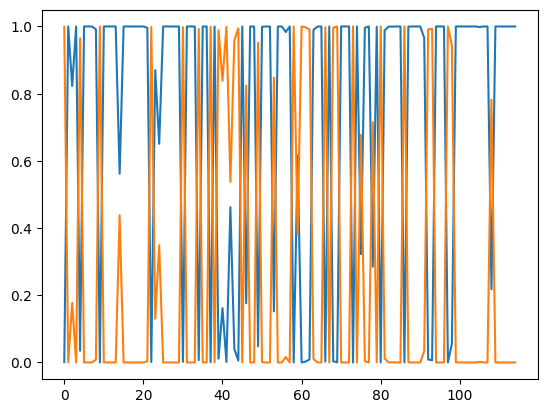

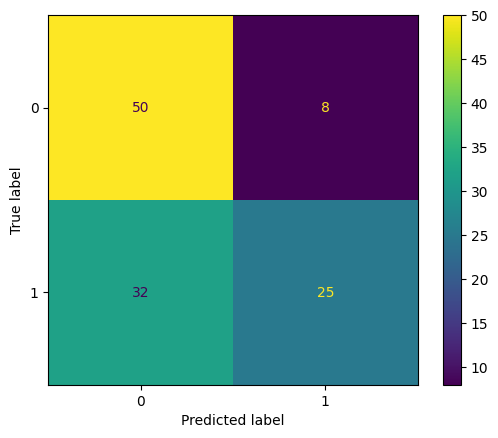

In [345]:
predicted = model.predict(df1)
tensor = torch.tensor(output_rows.values)
predic = tf.squeeze(predicted)


plt.plot(predic)

predict= np.array([np.argmax(row) for row in predic])
actual = np.array([np.argmax(row) for row in tensor])
conf_mat = confusion_matrix(actual, predict)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

In [346]:
def total_row_score(vector):
    vector[0][9] = sum(vector[0][0:9])
    vector[1][9] = sum(vector[1][0:9])
    print(vector)

In [347]:

xnew = np.array([[12, 0, 3, 0, 0, 6, 8, 0 ,3, 0],
                 [0, 0, 3, 0, 0, 0,8, 0, 3, 0]])

total_row_score(xnew)


new_prediction = model.predict(xnew.reshape(1,20))
new_prediction = tf.squeeze(new_prediction)

print(new_prediction)
predict_round(new_prediction)

[[12  0  3  0  0  6  8  0  3 32]
 [ 0  0  3  0  0  0  8  0  3 14]]
1/1 [==============================] - 0s 128ms/step
tf.Tensor([9.0847e-09 1.0000e+00], shape=(2,), dtype=float32)


'The estimate would be class 2 with a probability of 100.0'

In [471]:
Output = df.apply(pin_update, axis=1)
Output1 = df.apply(pin_update1, axis=1)
df['Output'] = Output
df['Output1'] = Output1


df1 = df[["Anteroposterior 1",
          'Anteroposterior 2',
          'Vertical 1',
          'Vertical 2',
          'Transverse',
          'Crowding ',
          'Spacing',
          'Tooth shape/size\r\n',
          "Pan 2\r\n",
          'Total Row Score A',
          'Anteroposterior 1.1',
          'Anteroposterior',
          'Vertical 1.1',
          'Vertical 2.1',
          'Transverse.1',
          'Crowding .2',
          'Spacing.1',
          'Tooth shape/size\r\n.1',
          'Pan 2\r\n.1',
          'Total Row Score B',
          'Output']]


df1 = df1.iloc[1:, :]

df1 = df1.dropna()


target_column = ["Output"]
numerical_column = df1.columns.drop(target_column)
output_rows = df1[target_column]
df1.drop(target_column,axis=1,inplace=True)


In [472]:
X_train, X_test, y_train, y_test = train_test_split(df1, output_rows, test_size=0.25,shuffle=False)

inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)


In [473]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()
logisticRegr = logisticRegr.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [474]:
prediction1 = logisticRegr.predict_proba(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)


0.5862068965517241


In [475]:
np.argmax(prediction1,axis = 1)

array([0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1])

In [476]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, np.argmax(prediction1,axis = 1))

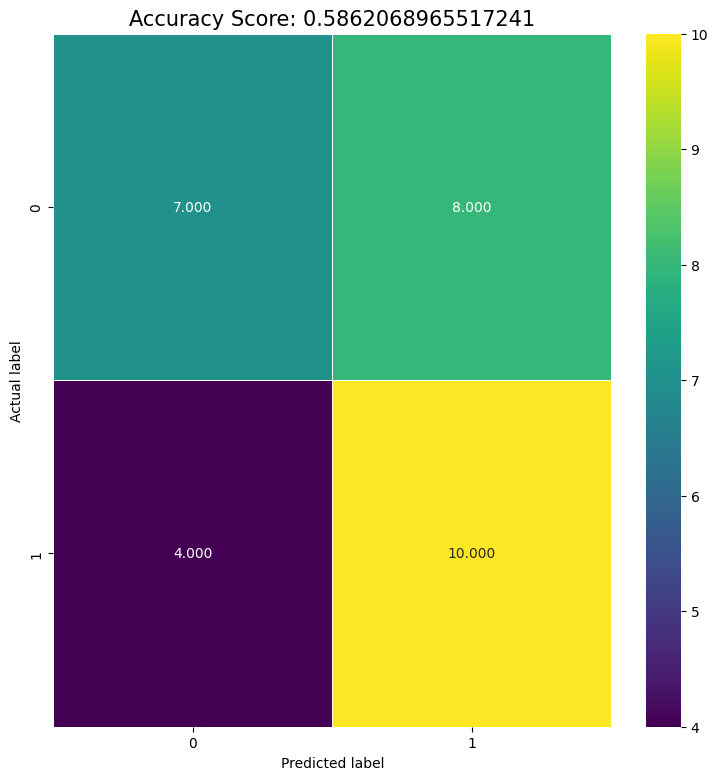

In [477]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = False, cmap = 'viridis');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [478]:
xnew = np.array([[12, 0, 3, 0, 0, 6, 8, 0 ,3, 0],
                 [12, 0, 3, 0, 0, 6, 8, 0, 3, 0]])

total_row_score(xnew)


logisticRegr.predict_proba(xnew.reshape(1,20))

[[12  0  3  0  0  6  8  0  3 32]
 [12  0  3  0  0  6  8  0  3 32]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.05290397, 0.94709603]])

In [479]:
# import pickle
# filename = 'finalized_model.sav'

# pickle.dump(logisticRegr, open(filename, 'wb'))

In [486]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')
clf.set_params(solver='lsqr')
clf.fit(X_train, y_train.values.ravel())
prediction2 = clf.predict_proba(X_test)
score = clf.score(X_test, y_test)
print(score)


cm = metrics.confusion_matrix(y_test, np.argmax(prediction2,axis = 1))
print(cm)

xnew = np.array([[12, 0, 3, 0, 0, 6, 8, 0 ,3, 0],
                 [12, 0, 3, 0, 0, 6, 8, 0, 3, 0]])

total_row_score(xnew)


clf.predict_proba(xnew.reshape(1,20))

0.5862068965517241
[[8 7]
 [5 9]]
[[12  0  3  0  0  6  8  0  3 32]
 [12  0  3  0  0  6  8  0  3 32]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


array([[0.08179241, 0.91820759]])

In [484]:
from sklearn.naive_bayes import CategoricalNB

cl1 = CategoricalNB(min_categories=2, alpha=1.0, fit_prior=True, class_prior=None)
cl1.fit(X_train, y_train.values.ravel())
prediction3 = cl1.predict_proba(X_test )
print(prediction3)
score = cl1.score(X_test, y_test)
print(score)


#cm = metrics.confusion_matrix(y_test, prediction3)
#print(cm)

xnew = np.array([[12, 0, 3, 0, 0, 6, 8, 0 ,3, 0],
                 [12, 0, 3, 0, 0, 6, 8, 0, 3, 0]])


total_row_score(xnew)


cl1.predict_proba(xnew.reshape(1,20))

[[8.95409741e-01 1.04590259e-01]
 [8.61774234e-01 1.38225766e-01]
 [3.41397697e-01 6.58602303e-01]
 [7.81546151e-04 9.99218454e-01]
 [2.35014293e-02 9.76498571e-01]
 [6.46549410e-01 3.53450590e-01]
 [9.51467195e-01 4.85328055e-02]
 [9.80933216e-01 1.90667841e-02]
 [3.03045756e-01 6.96954244e-01]
 [6.31821472e-01 3.68178528e-01]
 [1.57073895e-01 8.42926105e-01]
 [7.44070709e-01 2.55929291e-01]
 [8.94876876e-01 1.05123124e-01]
 [4.03659258e-03 9.95963407e-01]
 [2.41694492e-01 7.58305508e-01]
 [9.36938344e-03 9.90630617e-01]
 [2.96198566e-02 9.70380143e-01]
 [2.52250461e-01 7.47749539e-01]
 [2.23134943e-02 9.77686506e-01]
 [5.22760264e-01 4.77239736e-01]
 [3.90407424e-02 9.60959258e-01]
 [3.09202907e-01 6.90797093e-01]
 [9.90807235e-01 9.19276502e-03]
 [3.55125778e-05 9.99964487e-01]
 [1.55457603e-01 8.44542397e-01]
 [7.68867660e-01 2.31132340e-01]
 [2.08615967e-02 9.79138403e-01]
 [7.70553402e-01 2.29446598e-01]
 [7.71001156e-02 9.22899884e-01]]
0.6206896551724138
[[12  0  3  0  0  6  8 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(


IndexError: index 6 is out of bounds for axis 1 with size 5

In [ ]:
cl1.set_params(alpha=1.0, fit_prior=True)

cl1.fit(X_train, y_train.values.ravel())



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(


IndexError: index 6 is out of bounds for axis 1 with size 5

In [482]:
cl1.get_params()

{'alpha': 1.0,
 'class_prior': None,
 'fit_prior': True,
 'force_alpha': True,
 'min_categories': None}